(predictive)=
# Predictive Modeling

In this section we discuss the general predictive modeling process, model tuning, the problem of overfitting, and cross-validation. This draws on {cite}`kuhn2013applied` Chapters 2 and 4. ISL is also a good reference for the main ideas. However, I don't recommend either book for its treatment of cross-validation. Instead, consider [the scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html) and 

Both ISL (Ch 2) and APM (Ch 2 and 4) are suitable references. 

We also introduce AUC as a performance measure for binary classifiers. After the corresponding lectures, you should be prepared to read {cite}`ward2010perils` and {cite}`neunhoeffer2019cross`.  

This section introduces key concepts in the predictive modeling process, drawing on {cite}`kuhn2013applied` Chapters 2-4 and {cite}`varma2006bias`. After the corresponding lecture, you should be prepared to read {cite}`ward2010perils` and {cite}`neunhoeffer2019cross`. 

Read ISL chapters 2 and 5. 



## Predicting $\hat{y}$

Most of the machine learning models we will cover focus on prediction. In this world, we are not interested in marginal effects like the increase in wages attributable to schooling, standard errors, or even interpretability. Instead, we focus on some measure of predictive accuracy. A black box model is fine and a simpler model might only be preferred with parsimony as a tiebreaker.

## Tufte's Midterm Elections Model

Let's focus on regression problems where $y$ is a continuous scalar value. For concreteness, let's say we are predicting midterm election vote share like in {cite}`tufte1975determinants`. The $y$ variable is the percentage-point difference between the president's party's midterm two-party House vote share and that party's normal vote (average over the previous eight House elections). 

{cite}`tufte1975determinants` finds an equation 

$$\widehat{\text{Vote Loss}} = -11.08 + 0.035\times \Delta\text{Real Disposable Income} + 0.133\times \text{Presidential Approval}.$$

This line was found based on data from 1938-1970 and the R-squared is 0.912. Recall that R-squared describes how much of the variation in $y$ is captured by the model. A perfect model gives an R-squared of 1 and a model with only an intercept equal to the average of $y$ gives an R-squared of 0. Tufte's 0.912 is impressive. With intro stats training, you might only ask for the adjusted R-squared as a follow up. The adjusted R-squared is also impressive at 0.876. 

Adjusted R-squared is a blunt way to prevent being overconfident in your model. After all, we can add new features of random noise, uncorrelated to $y$ and improve the R-squared. With enough columns, the R-squared will become exactly 1. The adjusted R-squared formula essentially penalizes the R-squared based on the number of predictor variables and the number of observations. 

However, the usefulness of this as a predictive model hinges on model performance on elections *after* 1970. Evaluating the model on a **test set** of previously unseen data is more data driven and it answers the question of interest more exactly. The general principle is that a model should be evaluated with new data that wasn't used in the model training. Records from 1938-1970 form the **training set** and we can assemble data from 1974-2022 as a **test set**. 

Let's see how two modifications of Tufte's model holds up with test data. I was unable to replicate Tufte's Real Disposable Income variable, so I substitute a similar RDI measure using data available from the BEA. In our model 1, we include only the presidential approval variable: `vote_loss ~ presidential_approval`.  Model 2 is spiritually the same as Tufte's though: `vote_loss ~ change_rdi + presidential_approval`. 

We will see that none of these models performs very well on the test data. 

In [ ]:
# hide code and output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from predictive import calculate_out_of_sample_r2

url = 'https://raw.githubusercontent.com/alexanderthclark/pols4728/refs/heads/main/data/tufte_midterms.csv'
df = pd.read_csv(url)

# Tufte analysis
tufte_model = smf.ols(formula='vote_loss ~ pres_approval + delta_rdi', data=df[df.in_original==True]).fit()
tufte_model_sub = smf.ols(formula='vote_loss ~ pres_approval + dpi_pc_pct_yoy', data=df[df.in_original==True]).fit()
out_of_sample_average = sm.OLS(df[df.year > 1970].vote_loss, np.ones(13)).fit()
tufte_approval_only = smf.ols(formula='vote_loss ~ pres_approval', data=df[df.in_original==True]).fit()

df['single_lin_reg_residuals'] = df.vote_loss - tufte_approval_only.predict(df.pres_approval)
df['multi_reg_residuals'] = df.vote_loss - tufte_model_sub.predict(df[['pres_approval', 'dpi_pc_pct_yoy']])
df['multi_reg_predictions'] = tufte_model_sub.predict(df[['pres_approval', 'dpi_pc_pct_yoy']])

df1 = df[df.in_original==True]
df2 = df[df.year > 1970]

#calculate_out_of_sample_r2(tufte_approval_only, df2)
#calculate_out_of_sample_r2(tufte_model_sub, df2)

### Model 1

Model 1 has an R-squared of 0.253 in the training set. From the scatter plot below, we can see that the regression line is sane but imperfect when compared to the test data. The R-squared is just 0.015 on the test set. That means using the regression model is not much better than just guessing the average from the post-1970 data. 

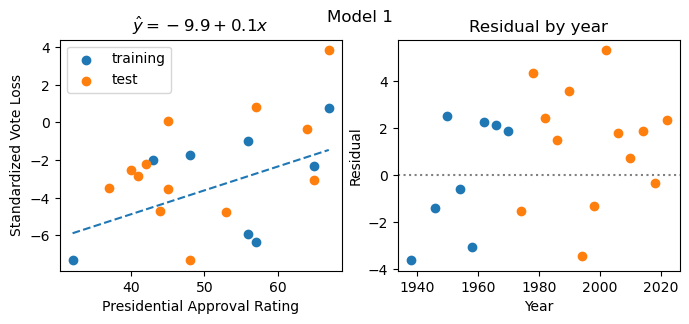

In [253]:
# Hide code, show output
eq = r"$\hat{y} = " + fr"{tufte_approval_only.params.iloc[0]:+.1f}{tufte_approval_only.params.iloc[1]:+.1f}x$"

fig, axs = plt.subplots(1,2, figsize=(8,3))

ax = axs[0]
y = df1.vote_loss
ax.scatter(df1.pres_approval, y, color='C0', label='training')
y = df2.vote_loss
ax.scatter(df2.pres_approval, y, color='C1', label='test')

ax.set_ylabel("Standardized Vote Loss") 
ax.set_xlabel("Presidential Approval Rating")
ax.set_title(eq)
ax.legend()

x0, x1 = df1.pres_approval.min(), df1.pres_approval.max()
y0 = tufte_approval_only.params.values @ np.array([1, x0])
y1 = tufte_approval_only.params.values @ np.array([1, x1])
ax.plot([x0, x1], [y0, y1], ls='dashed')

# residuals
ax = axs[1]
ax.set_title("Residual by year")
ax.scatter(df1.year, df1.single_lin_reg_residuals)
ax.scatter(df2.year, df2.single_lin_reg_residuals)
ax.axhline(0, ls='dotted', color='gray')
ax.set_ylabel("Residual")
ax.set_xlabel("Year")

plt.suptitle('Model 1')
plt.show()

### Model 2

Model 1 has an R-squared of 0.876 in the training set. From the residual scatter below, we see that the residuals become more volatile over time. Indeed, the R-squared is -0.233 (yes, negative) for the test data. That means using the regression model is worse than just guessing the average from the post-1970 data. 

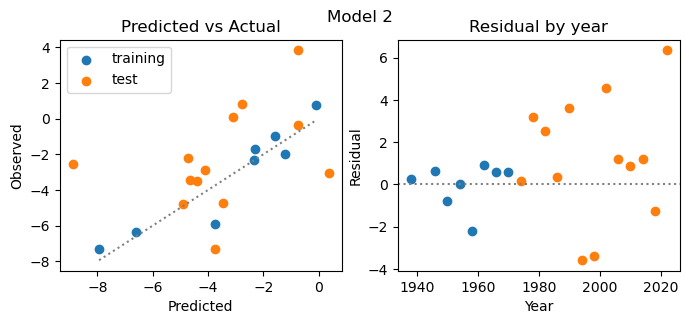

In [250]:
# hide code, show output 

fig, axs = plt.subplots(1,2, figsize=(8,3))

ax = axs[0]

ax.scatter(df1.multi_reg_predictions, df1.vote_loss, label='training') 
ax.scatter(df2.multi_reg_predictions, df2.vote_loss, label='test') 
ax.set_xlabel("Predicted")
ax.set_ylabel("Observed")
ax.set_title("Predicted vs Actual")

d = df1.multi_reg_predictions.min(), df1.multi_reg_predictions.max()
ax.plot(d, d, color='gray', ls='dotted')

ax.legend()


ax = axs[1]
ax.scatter(df1.year, df1.multi_reg_residuals)
ax.scatter(df2.year, df2.multi_reg_residuals)
ax.axhline(0, ls='dotted', color='gray')
ax.set_ylabel("Residual")
ax.set_xlabel("Year")
ax.set_title("Residual by year")

plt.suptitle("Model 2")
plt.show()

## Could Tufte have produced a better model?

Above we see that model 1 is actually better than model 2 on test data. This is a case where a simple model generalizes to new data better. Should Tufte have known this? Probably not. He didn't have access to the test data. To perform model selection, he would have needed to reserve some of his eight observations for validation. With more data, we should be able to do better. The next section tries to make that process more clear. 

# Training, Testing, Overfitting

## Bias-Variance Tradeoff

There is in general a tradeoff between a model's *bias* and its *variance*. Bias refers to the difference between the truth and what your model predits. Variance refers to the tendency for the exact model fit to vary according to the randomness of the data you have. Both are bad. We like unbiased models and we want low variance so that our predictions are more exact. 

More complicated models tend to have higher variance. As you add more features or polynomial terms to a linear regression, your model is more sensitive to noise. However, a more simplistic model won't come as close to describing the data generating process as it really is. Thus a simple model is biased. 

When we decide on a performance metric like mean squared error (MSE) we are saying that we are willing to trade a reduction in one for an increase in the other. This is somewhat different than an emphasis on unbiased models (OLS is the BLUE) you might be familiar with in other settings. 

### Bias–Variance Decomposition (supervised prediction)

**Data-generating process**
- $Y = f(X) + \varepsilon$
- $\mathbb{E}[\varepsilon \mid X] = 0$, $\mathbb{Var}(\varepsilon \mid X) = \sigma^2(X)$
- $\hat f$ is a fitted model (random through the training sample/algorithm)

Define the test MSE at $x$:
$$
\mathrm{MSE}(x) \;=\; \mathbb{E}\!\left[(Y - \hat f(x))^2 \mid X=x\right].
$$

Substitute $Y=f(x)+\varepsilon$:
$$
\begin{aligned}
\mathrm{MSE}(x)
&= \mathbb{E}\!\left[(f(x)+\varepsilon-\hat f(x))^2 \mid X=x\right] \\
&= \mathbb{E}\!\left[(f(x)-\hat f(x))^2 \mid X=x\right] + \mathbb{E}[\varepsilon^2 \mid X=x] + 2\,\mathbb{E}\!\left[\varepsilon\{f(x)-\hat f(x)\}\mid X=x\right].
\end{aligned}
$$

Because $\mathbb{E}[\varepsilon\mid X=x]=0$ and the test noise $\varepsilon$ is independent of the training randomness in $\hat f$, the cross term is $0$. Hence
$$
\mathrm{MSE}(x) \;=\; \underbrace{\mathbb{E}\!\left[(f(x)-\hat f(x))^2\right]}_{\text{estimation error}}
\;+\; \underbrace{\sigma^2(x)}_{\text{irreducible noise}}.
$$

Now split the estimation error into bias$^2$ and variance:
$$
\begin{aligned}
\mathbb{E}\!\left[(f(x)-\hat f(x))^2\right]
&= \mathbb{E}\!\left[(\hat f(x)-\mathbb{E}[\hat f(x)] + \mathbb{E}[\hat f(x)]-f(x))^2\right] \\
&= \mathbb{E}\!\left[(\hat f(x)-\mathbb{E}[\hat f(x)])^2\right] + (\mathbb{E}[\hat f(x)]-f(x))^2 + 2\,\mathbb{E}\!\left[(\hat f(x)-\mathbb{E}[\hat f(x)])(\mathbb{E}[\hat f(x)]-f(x))\right] \\
&= \underbrace{\mathbb{Var}(\hat f(x))}_{\text{variance}} + \underbrace{(\mathbb{E}[\hat f(x)]-f(x))^2}_{\text{bias}^2},
\end{aligned}
$$
since the cross term is zero (the second factor is constant with respect to the expectation over training randomness).

**Therefore**
$$
\boxed{\ \mathrm{MSE}(x)
= \underbrace{(\mathbb{E}[\hat f(x)]-f(x))^2}_{\text{bias}^2(x)}
+ \underbrace{\mathbb{Var}(\hat f(x))}_{\text{variance}(x)}
+ \underbrace{\sigma^2(x)}_{\text{irreducible noise}}\ }.
$$

### Interpretation

- **Bias**: systematic error from model misspecification/rigidity.  
- **Variance**: sensitivity to the particular training sample.  
- **Noise**: randomness you cannot remove.

Making the model more flexible typically **reduces bias** but **increases variance**; restricting it does the opposite. Optimal predictive performance sits where bias$^2$ + variance is minimized (the noise term is fixed).

### Examples

Let $f(x) = \sin x + \varepsilon$, where $\varepsilon$ is normally distributed, iid noise. Suppose we observe $x$ drawn uniformly from $[0,\pi]$ so we only have the symmetric inverted-U shape.

/var/folders/6n/9nyvysy95t32yd_040h7yx4w0000gn/T/ipykernel_80841/1912773428.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, y_lin, 'r-', label='Linear fit', lw=2, color='C1')
/var/folders/6n/9nyvysy95t32yd_040h7yx4w0000gn/T/ipykernel_80841/1912773428.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(x, y_quad, 'g-', label='Quadratic fit', lw=2, color='C2')


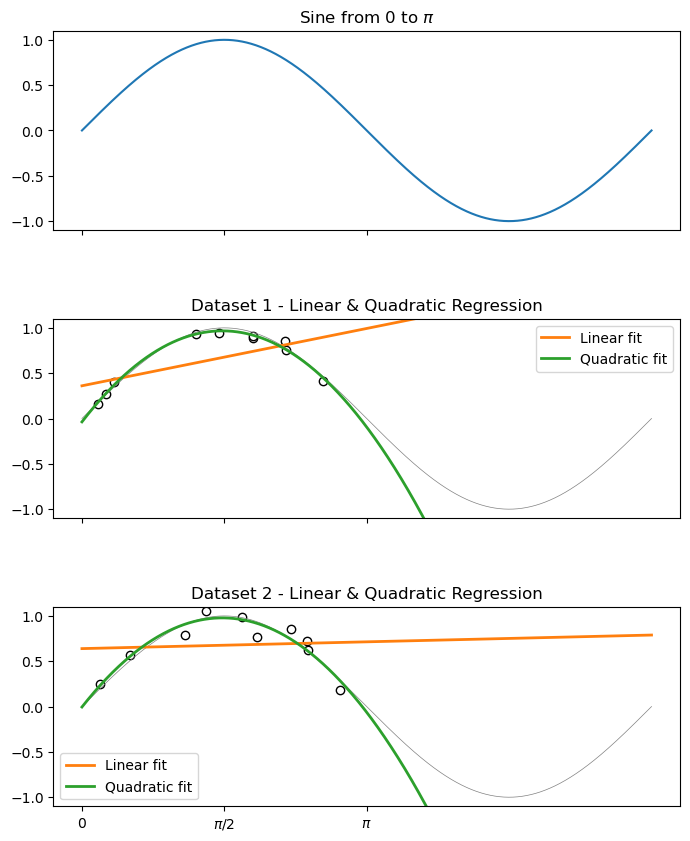

In [297]:
# hide code and show output
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(11)

x = np.linspace(0, np.pi, 1_000)
x = np.linspace(0, 2*np.pi, 2_000)
y = np.sin(x)
n_axs = 3
fig, axs = plt.subplots(n_axs,1, figsize=(7,9), sharex=True, sharey=True)
ax = axs[0]
ax.set_aspect(1)
ax.plot(x_long, np.sin(x_long))
ax.set_title(r"Sine from 0 to $\pi$")
ax.set_xticks([0, np.pi/2, np.pi])
ax.set_xticklabels(['0', r"$\pi/2$", r"$\pi$"]) 

xlim, ylim = ax.get_xlim(), ax.get_ylim()

data_sets = dict()
n_sims = 100
n=10
for i in range(n_sims):
    x0 = np.random.uniform(0, np.pi, size=n)
    noise = np.random.normal(0, 0.1, size=n)
    y0 = np.sin(x0) + noise
    if 0 < i < n_axs:
        ax = axs[i]
        ax.set_aspect(1)
        ax.plot(x_long,np.sin(x_long), lw=0.5, color='gray')
        ax.scatter(x0, y0, ec='black', fc='white')
        
        # Add both linear and quadratic regression for axs[1] and axs[2]
        p1 = np.polyfit(x0, y0, 1)
        y_lin = np.polyval(p1, x)
        ax.plot(x, y_lin, 'r-', label='Linear fit', lw=2, color='C1')
        
        p2 = np.polyfit(x0, y0, 2)
        y_quad = np.polyval(p2, x)
        ax.plot(x, y_quad, 'g-', label='Quadratic fit', lw=2, color='C2')
        
        ax.legend()
        ax.set_title(f"Dataset {i} - Linear & Quadratic Regression")

for ax in axs:
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
        
plt.tight_layout()
plt.show()

In the above, the simpler model will perform much better if the distribution of $x$ values shifts (technically called covariate shift), so that we start observing values $x>\pi$. The more complex, quadratic model is probably better in all other circumstances. 

Sometimes the simpler model is better for any sample of $x$ values from the same distribution. This is a more pure bias variance tradeoff. Suppose instead the actual data generating process is one of pure noise $g(x) = \varepsilon$, but that there is a lot of noise so the standard deviation of the noise is high. The quadratic model is *correctly specified* but, because it is so sensitive to the noise, it might not perform as well as the biased linear model with lower variance. 




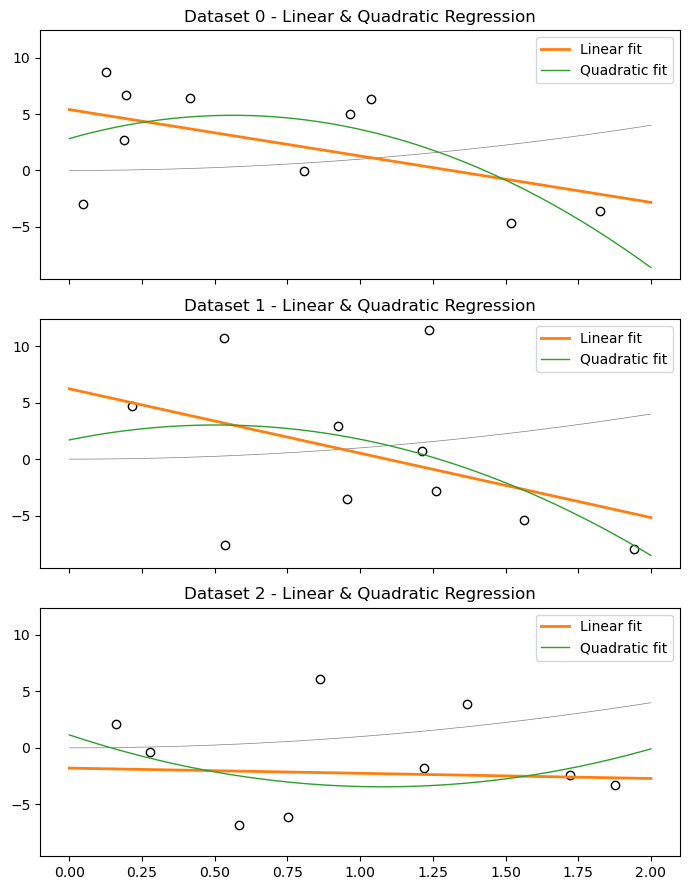

In [319]:
# hide code and show output 
x = np.linspace(0, 2, 2_000)
y = x**2 #np.zeros(len(x))
n_axs = 3
fig, axs = plt.subplots(n_axs,1, figsize=(7,9), sharex=True, sharey=True)

#xlim, ylim = ax.get_xlim(), ax.get_ylim()

data_sets = dict()
n_sims = 100
n=10
for i in range(0, n_axs):
    x0 = np.random.uniform(0, 2, size=n)
    noise = np.random.normal(0, 6, size=n)
    y0 =  noise
    
    ax = axs[i]
    ax.plot(x, y, lw=0.5, color='gray')
    ax.scatter(x0, y0, ec='black', fc='white')
    
    # Add both linear and quadratic regression for axs[1] and axs[2]
    p1 = np.polyfit(x0, y0, 1)
    y_lin = np.polyval(p1, x)
    ax.plot(x, y_lin, label='Linear fit', lw=2, color='C1')
    
    p2 = np.polyfit(x0, y0, 2)
    y_quad = np.polyval(p2, x)
    ax.plot(x, y_quad, label='Quadratic fit', lw=1, color='C2')
    
    ax.legend()
    ax.set_title(f"Dataset {i} - Linear & Quadratic Regression")

ax.relim()
        
plt.tight_layout()
plt.show()

# James-Stein

In [20]:
import numpy as np

In [76]:
import numpy as np
rng = np.random.default_rng(0)

p = 3
theta = np.array([50, -1.0, 10])   # any fixed 3-vector
theta = np.array([0,0,0])   # any fixed 3-vector

R = 1_000_000                             # Monte Carlo replications

# One-shot normal-means: Y ~ N(theta, I_p)
Y  = theta + rng.normal(size=(R, p))
r2 = np.sum(Y**2, axis=1)

# James–Stein shrinkage factors (σ² = 1)
a  = 1 - (p - 2) / r2                   # untruncated JS
ap = np.maximum(0.0, a)                 # positive-part JS

# Squared-error losses
mle_se = np.sum((Y - theta)**2, axis=1)
mle_se2 = np.linalg.norm(Y-theta, axis=1)**2
js_se2 = np.linalg.norm((a[:, None]  * Y) -theta, axis=1)**2

js_se  = np.sum(((a[:, None]  * Y) - theta)**2, axis=1)
jsp_se = np.sum(((ap[:, None] * Y) - theta)**2, axis=1)

print("Normal-means (p=3, σ²=1)")
print(f"MLE risk ≈ {mle_se.mean():.6f}")
print(f"MLE risk ≈ {mle_se2.mean():.6f}")
print(f"JS  risk ≈ {js_se2.mean():.6f}")

print(f"JS  risk ≈ {js_se.mean():.6f}")
print(f"JS+ risk ≈ {jsp_se.mean():.6f}")


Normal-means (p=3, σ²=1)
MLE risk ≈ 2.998622
MLE risk ≈ 2.998622
JS  risk ≈ 1.982706
JS  risk ≈ 1.982706
JS+ risk ≈ 1.601375


# Summary

We've now learned about the predictive modeling process. Model tuning and selection is prone to the problem of over-fitting. Performance measures like R-squared (and adjusted R-squared) are misleading when calculated based on training data. A model's performance can only truly be measured by using completely new test data that was not involved in the training process. The researcher needs to remain disciplined and use procedures like cross-validation to make model selection more systematic, transparent, and reliable. [As noted by Susan Athey](https://www.econtalk.org/susan-athey-on-machine-learning-big-data-and-causation/), instead of researchers subjectively choosing variables and testing specifications behind the scenes, we can now explicitly use data to determine which variables matter. This technological shift enables what {cite}`grimmer2021machine` describe as a move away from purely deductive social science toward a more inductive, iterative approach where researchers can discover patterns in data rather than only testing pre-specified hypotheses.

# Exercises

```{exercise-start}
:label: tufte
```

Using `tufte_midterms.csv`, build a few models uising on the data from 1970 and earlier. Compare the test R-squared for the different model specifications. What specification performs best? 

```{exercise-end}
```


```{exercise-start}
:label: CV-selection
```

Lisa and Bart are trying to find the best model to predict the quantities of oil underground. Lisa chooses her model by (1) dividing her data into test and training. (2) She compares the performance of several different models and hyperparameter settings using 5-fold cross validation on the the training set. Each model is trained five times and evaluated on the five different holdout folds. She obtains an estimate of the model performance by averaging over each of the five evaluations. (3) She picks the winning model and tuning parameters based on the CV procedure. (4) She uses the test set at the end to get a final measure of performance for the selected model. 

Bart uses a similar procedure but he picks the winner by using the *test* set. He uses CV to tune different types of models. Then, he compares each tuned model on the test set and picks the model with the best performance. 

Who uses cross validation correctly? Lisa? Bart? Both? Neither? 

```{exercise-end}
```


```{exercise-start}
:label: phack
```

In what ways are p-hacking and overfitting similar? In what ways are they different? 

```{exercise-end}
```